<a href="https://colab.research.google.com/github/HarshJ23/Credit-risk-prediction/blob/main/credit_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:42:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Logistic Regression Results:
AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1702
           1       0.89      1.00      0.94       298

    accuracy                           0.98      2000
   macro avg       0.95      0.99      0.97      2000
weighted avg       0.98      0.98      0.98      2000


XGBoost Results:
AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1702
           1       0.95      1.00      0.97       298

    accuracy                           0.99      2000
   macro avg       0.97      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000


Deep Learning Results:
AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1702
           1       0.99      1.00      1.00       298

    accuracy                          

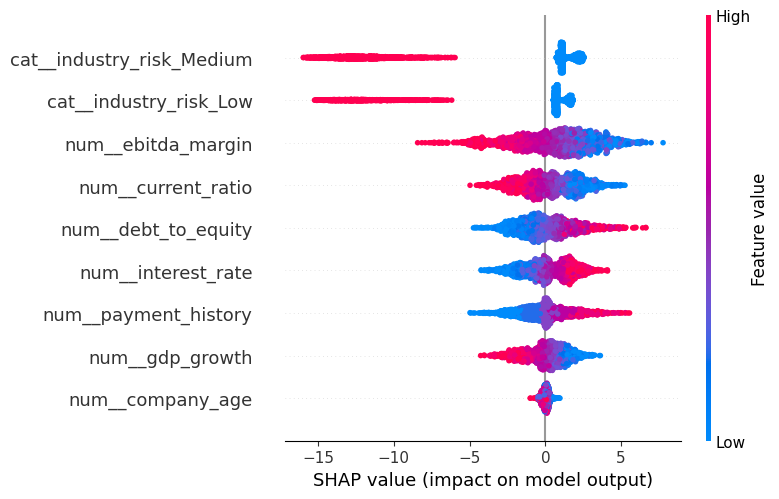


Scenario Analysis: {'Baseline': 0.7772249, 'Recession': 0.7772249, 'Boom': 0.7772249}


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import shap
from imblearn.over_sampling import SMOTE

# 1. Enhanced Synthetic Data Generation
np.random.seed(42)
num_samples = 10000

# Create more realistic feature relationships
data = {
    'company_age': np.random.randint(1, 50, num_samples),
    'debt_to_equity': np.random.lognormal(mean=0, sigma=0.5, size=num_samples),
    'current_ratio': np.random.uniform(0.5, 3.0, num_samples),
    'ebitda_margin': np.random.normal(loc=0.1, scale=0.05, size=num_samples),
    'payment_history': np.random.poisson(lam=2, size=num_samples),
    'industry_risk': np.random.choice(['High', 'Medium', 'Low'],
                                     p=[0.2, 0.5, 0.3], size=num_samples),
    'gdp_growth': np.random.normal(loc=0.02, scale=0.01, size=num_samples),
    'interest_rate': np.random.uniform(0.01, 0.1, size=num_samples)
}

# Create realistic target variable based on features
def create_target(row):
    score = 0
    score += row['debt_to_equity'] * 0.3
    score -= row['current_ratio'] * 0.2
    score -= row['ebitda_margin'] * 5
    score += row['payment_history'] * 0.1
    score += (row['industry_risk'] == 'High') * 2
    score -= (row['industry_risk'] == 'Low') * 1
    score -= row['gdp_growth'] * 10
    score += row['interest_rate'] * 5
    return 1 if score > 1.5 else 0

df = pd.DataFrame(data)
df['default_flag'] = df.apply(create_target, axis=1)

# 2. Improved Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = ['company_age', 'debt_to_equity', 'current_ratio',
                   'ebitda_margin', 'payment_history', 'gdp_growth',
                   'interest_rate']
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_features = ['industry_risk']
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = df.drop('default_flag', axis=1)
y = df['default_flag']

# Apply preprocessing
X = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# 3. Class balancing with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 4. Model Development with Class Weights
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_bal, y_train_bal)
y_pred_lr = lr.predict_proba(X_test)[:,1]

# XGBoost with better parameters
xgb = XGBClassifier(
    scale_pos_weight=(y_train_bal == 0).sum()/(y_train_bal == 1).sum(),
    eval_metric='logloss',
    use_label_encoder=False
)
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict_proba(X_test)[:,1]

# Deep Learning
input_dim = X_train_bal.shape[1]
dl_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dl_model.compile(optimizer='adam', loss='binary_crossentropy')
dl_model.fit(X_train_bal, y_train_bal,
             epochs=50, batch_size=64,
             validation_split=0.2, verbose=0)
y_pred_dl = dl_model.predict(X_test).flatten()

# 5. Evaluation
def evaluate(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print(f"AUC: {roc_auc_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, (y_pred > 0.5).astype(int)))

evaluate("Logistic Regression", y_test, y_pred_lr)
evaluate("XGBoost", y_test, y_pred_xgb)
evaluate("Deep Learning", y_test, y_pred_dl)

# 6. SHAP Explanation (Fixed)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out())

# 7. Scenario Analysis
def scenario_analysis(model):
    scenarios = {
        'Baseline': {'gdp_growth': 0.02, 'interest_rate': 0.05},
        'Recession': {'gdp_growth': -0.01, 'interest_rate': 0.08},
        'Boom': {'gdp_growth': 0.04, 'interest_rate': 0.03}
    }

    results = {}
    for name, params in scenarios.items():
        X_scenario = X.copy()
        # Update macro variables (assuming they're the last two features)
        X_scenario[:, -2] = params['gdp_growth']
        X_scenario[:, -1] = params['interest_rate']
        prob = model.predict_proba(X_scenario)[:,1].mean()
        results[name] = prob
    return results

print("\nScenario Analysis:", scenario_analysis(xgb))